# Problem 1

## Problem description

This problem was posted originally [here](https://stats.stackexchange.com/questions/188141/train-waiting-time-in-probability). I reproduce it below for the sake of completness.

"Let's say a train arrives at a stop every 15 or 45 minutes with equal probability (1/2). What is the expected waiting time of a passenger for the next train if this passenger arrives at the stop at any random time. This means that the passenger has no sense of time nor know when the last train left and could enter the station at any point within the interval of 2 consecutive trains.

I was told 15 minutes was the wrong answer and my machine simulated answer is 18.75 minutes. I just don't know the mathematical approach for this problem and of course the exact true answer. Sincerely hope you guys can help me."

## Problem solution (simulation)

We assume that the trains are always on time either every 15 or 45 minutes, both with probability 0.5. 
1. We consider a realization of such a train schedule for a large number of trains (num_trains).
2. Once a schedule is known, a large number of passengers (num_passengers) arrives uniformaly at random during the total duration of the train schedule. 
3. Passengers are assigned to the corresponding next train in the schedule and their waiting time is calculated.
4. The mean of these waiting times is computed.
5. We repeat steps 1-4 a large number of times (N) to estimate the distribution of the mean waiting time.
6. Finally, we approximate the mean waiting time by averaging the quantities from step 5. 

Mathematically
---
Let $X$ be the waiting time of a passenger from the moment that he arrives to the train platform to the moment when the next train arrives according to a schedule realization. Let $t_{15}$ and $t_{45}$ be the events that this next train arrives 15 or 45 minutes after the previous departed train.

$$E(X) = E(X|t_{15})P(t_{15}) + E(X|t_{45})P(t_{45})$$

Since the passenger arrives uniformly at random between consequetive trains, then his arrival time can be modelled by a uniform distribution $Unif(t)$, where $t=15$ or 45 depending when the next train arrives. So
$E(X|t_{15}) = \frac{15}{2}$ and $E(X|t_{45}) = \frac{45}{2}$.

Given a realization of a schedule, on average half of the interarrival train intervals lasts 15 minuets and the other half lasts 45 minutes. However, the long interarrival intervals last 3 times more than the short ones. So a passenger arriving to the platform has 3 times more chances to do it during a long interarrival train interval than during a short one. This implies that $P(t_{15}) = \frac{1}{4}$ and $P(t_{45}) = \frac{3}{4}$.

Finally, substitution all quantities we get

$$E(X) = E(X|t_{15})P(t_{15}) + E(X|t_{45})P(t_{45}) = \frac{15}{2}\cdot\frac{1}{4} + \frac{45}{2}\cdot\frac{3}{4} = \frac{150}{8} = 18.75$$

## Functions for calculations

In [25]:
# Compute_mean_wait_time: Generates train schedules and passengers' arrival time,
# returns mean of passengers' waiting times for boarding next train (min).
#
# INPUT:
# num_trains      = (integer) total number of trains considered.
# num_passengers  = (integer) total number of passengers considered.
# intertime_short = (float) short interarrival time of train (min).
# intertime_long  = (float) long interarrival time of train (min).
# prob_short      = (float) probability train has SHORT interarrival time.
#
# OUTPUT:
# (float) mean of waiting times to next train (min).
Compute_mean_wait_time = function(
  num_trains, 
  num_passengers,
  intertime_short, 
  intertime_long,  
  prob_short){     
  
  # Generate series of trains' interarrival times. 
  # Short and long interarrival times appear with 
  # probabilities prob_short and prob_long = 1 - prob_short, respectively.
  intervals_train = sample(
    x = c(intertime_short, intertime_long), 
    size = num_trains,
    replace = TRUE,
    prob = c(prob_short, 1 - prob_short ))
  
  # Generate train's schedule
  schedule_train = cumsum(intervals_train)
  schedule_length = tail(schedule_train, n = 1)
  
  # Generate (random) arrival times for passengers  
  arrivaltime_passengers = runif(
      n = num_passengers, 
      min = 0, 
      max = schedule_length)
  
  # Find train time intervals corresponding to the moment 
  # when passengers arrive to platform
  i_passengers = findInterval(arrivaltime_passengers, schedule_train)
  
  # Compute passengers' waiting times for boarding next available train
  waittime_passengers = schedule_train[i_passengers + 1] - arrivaltime_passengers
  
  return(mean(waittime_passengers, na.rm = TRUE))
}

## Calculations

In [33]:
# Generate N approximations/experiments
N = 1000
ans = sapply(1:N, function(i){
    Compute_mean_wait_time(
      num_trains = 10000,
      num_passengers = 50000,
      intertime_short = 15,
      intertime_long = 45,
      prob_short = 0.5)
})
df = data.frame(experiment = 1:length(ans),
                wait_time = ans)

## Display results

In [43]:
library(dplyr)

# Experiments results
df %>% head(3)
cat('Estimated mean waiting time:', mean(df$wait_time), 'minutes')

experiment,wait_time
1,18.74555
2,18.82128
3,18.82400


Estimated mean waiting time: 18.75295 minutes

## Visualize results

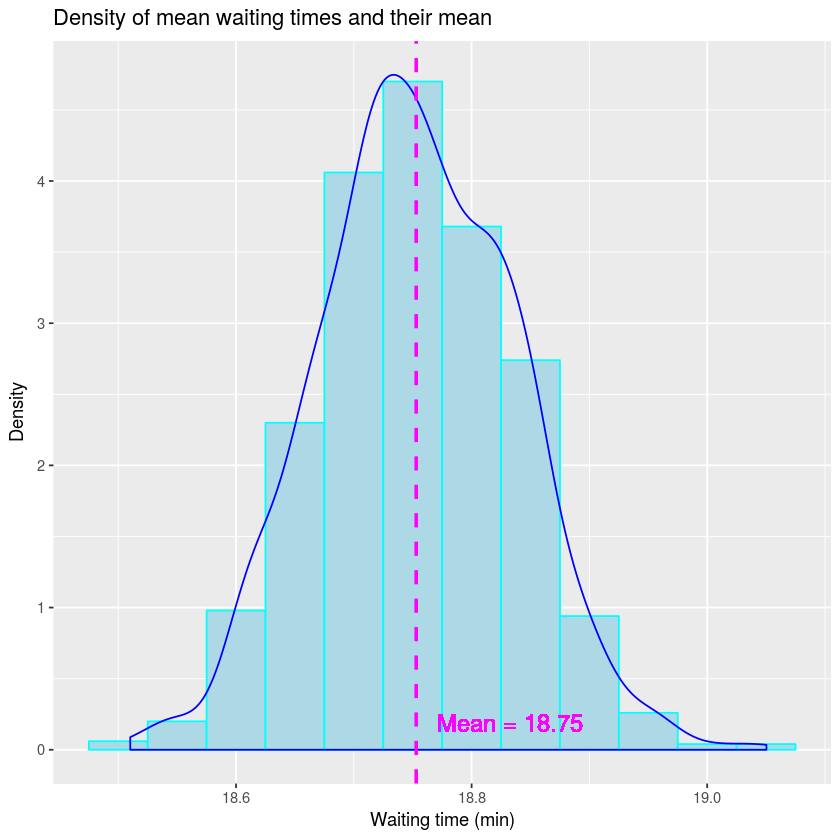

In [37]:
library(ggplot2)

ggplot(data = df, aes(wait_time)) + 
# Display histogram and density
  geom_histogram(aes(y = ..density..), 
                 col = 'cyan',
                 binwidth = 0.05,
                 fill = 'lightblue', 
                 alpha = 1) + 
  geom_density(col = 'blue') + 
  labs(title = 'Density of mean waiting times and their mean', 
       x = 'Waiting time (min)', 
       y = 'Density') + 
# Display mean vertical line
  geom_vline(aes(xintercept = mean(wait_time)),
             col = 'magenta', 
             size = 1,
             linetype = 'dashed') +
# Display mean value
  geom_text(aes(label = paste('Mean =', round(mean(wait_time), 2)),
                y = 0,
                x = mean(wait_time) + 0.08),
            vjust = -1,
            col = 'magenta',
            size = 5)
